### Contextual bandits: Make targeted decisions

Contextual bandits are typified by a recommmender system. Below, we simulate a system that recommends actions, such as movies from different movie genres to a user. Initially, the system makes random movie recommendations to users. The viewing time of users for the posts served them is measured. The different movie genres are the actions. The user features are called the context. The viewing times are called the reward.

The dataset is divided into subsets for each of the actions eg movies. The subsets are used to train models that predict a user's viewing time (reward) from user characteristics (context) for each movie. Then for each user (context) we use each action's model to predict viewing time and choose the action that maximizes viewing time. Each day's predictions are made based on a model trained on the previous day's data. As the recommender learns to serve the right content, the expectation is that viewing times increase.

This is a greedy recommender system, because its always showing the action with the highest predicted viewing time. In other words, the greedy recommender system is in a constant state of exploitation, a term from bandit algorithms. The problem with this is that, it becomes a constant feedback loop of each context being shown the same actions, and this doesnt allow users to discover other things they may like. The solution is to include some exploration, another bandit algorithm term. 

Contextual bandit procedure allow us to find the right values for moodel parameters for predicting reward of an action based on context features.

In [3]:
import numpy as np 
import scipy 
import scipy.stats 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from e4e import E4E

e4e = E4E(chapter=5)

#### Simulate the viewing time

In [4]:
def measure_viewing_time(context,           # context is the user features; action is post chosen by system
                         action_weights):   # action_weights is a constant vector (ie learned weights)
    return np.exp((context*action_weights).mean()       # expectation
                  + 0.1*np.random.normal()              # noise fluctuation
                  ) # reward (viewing time) is a positive, noisy number that depends on context and action

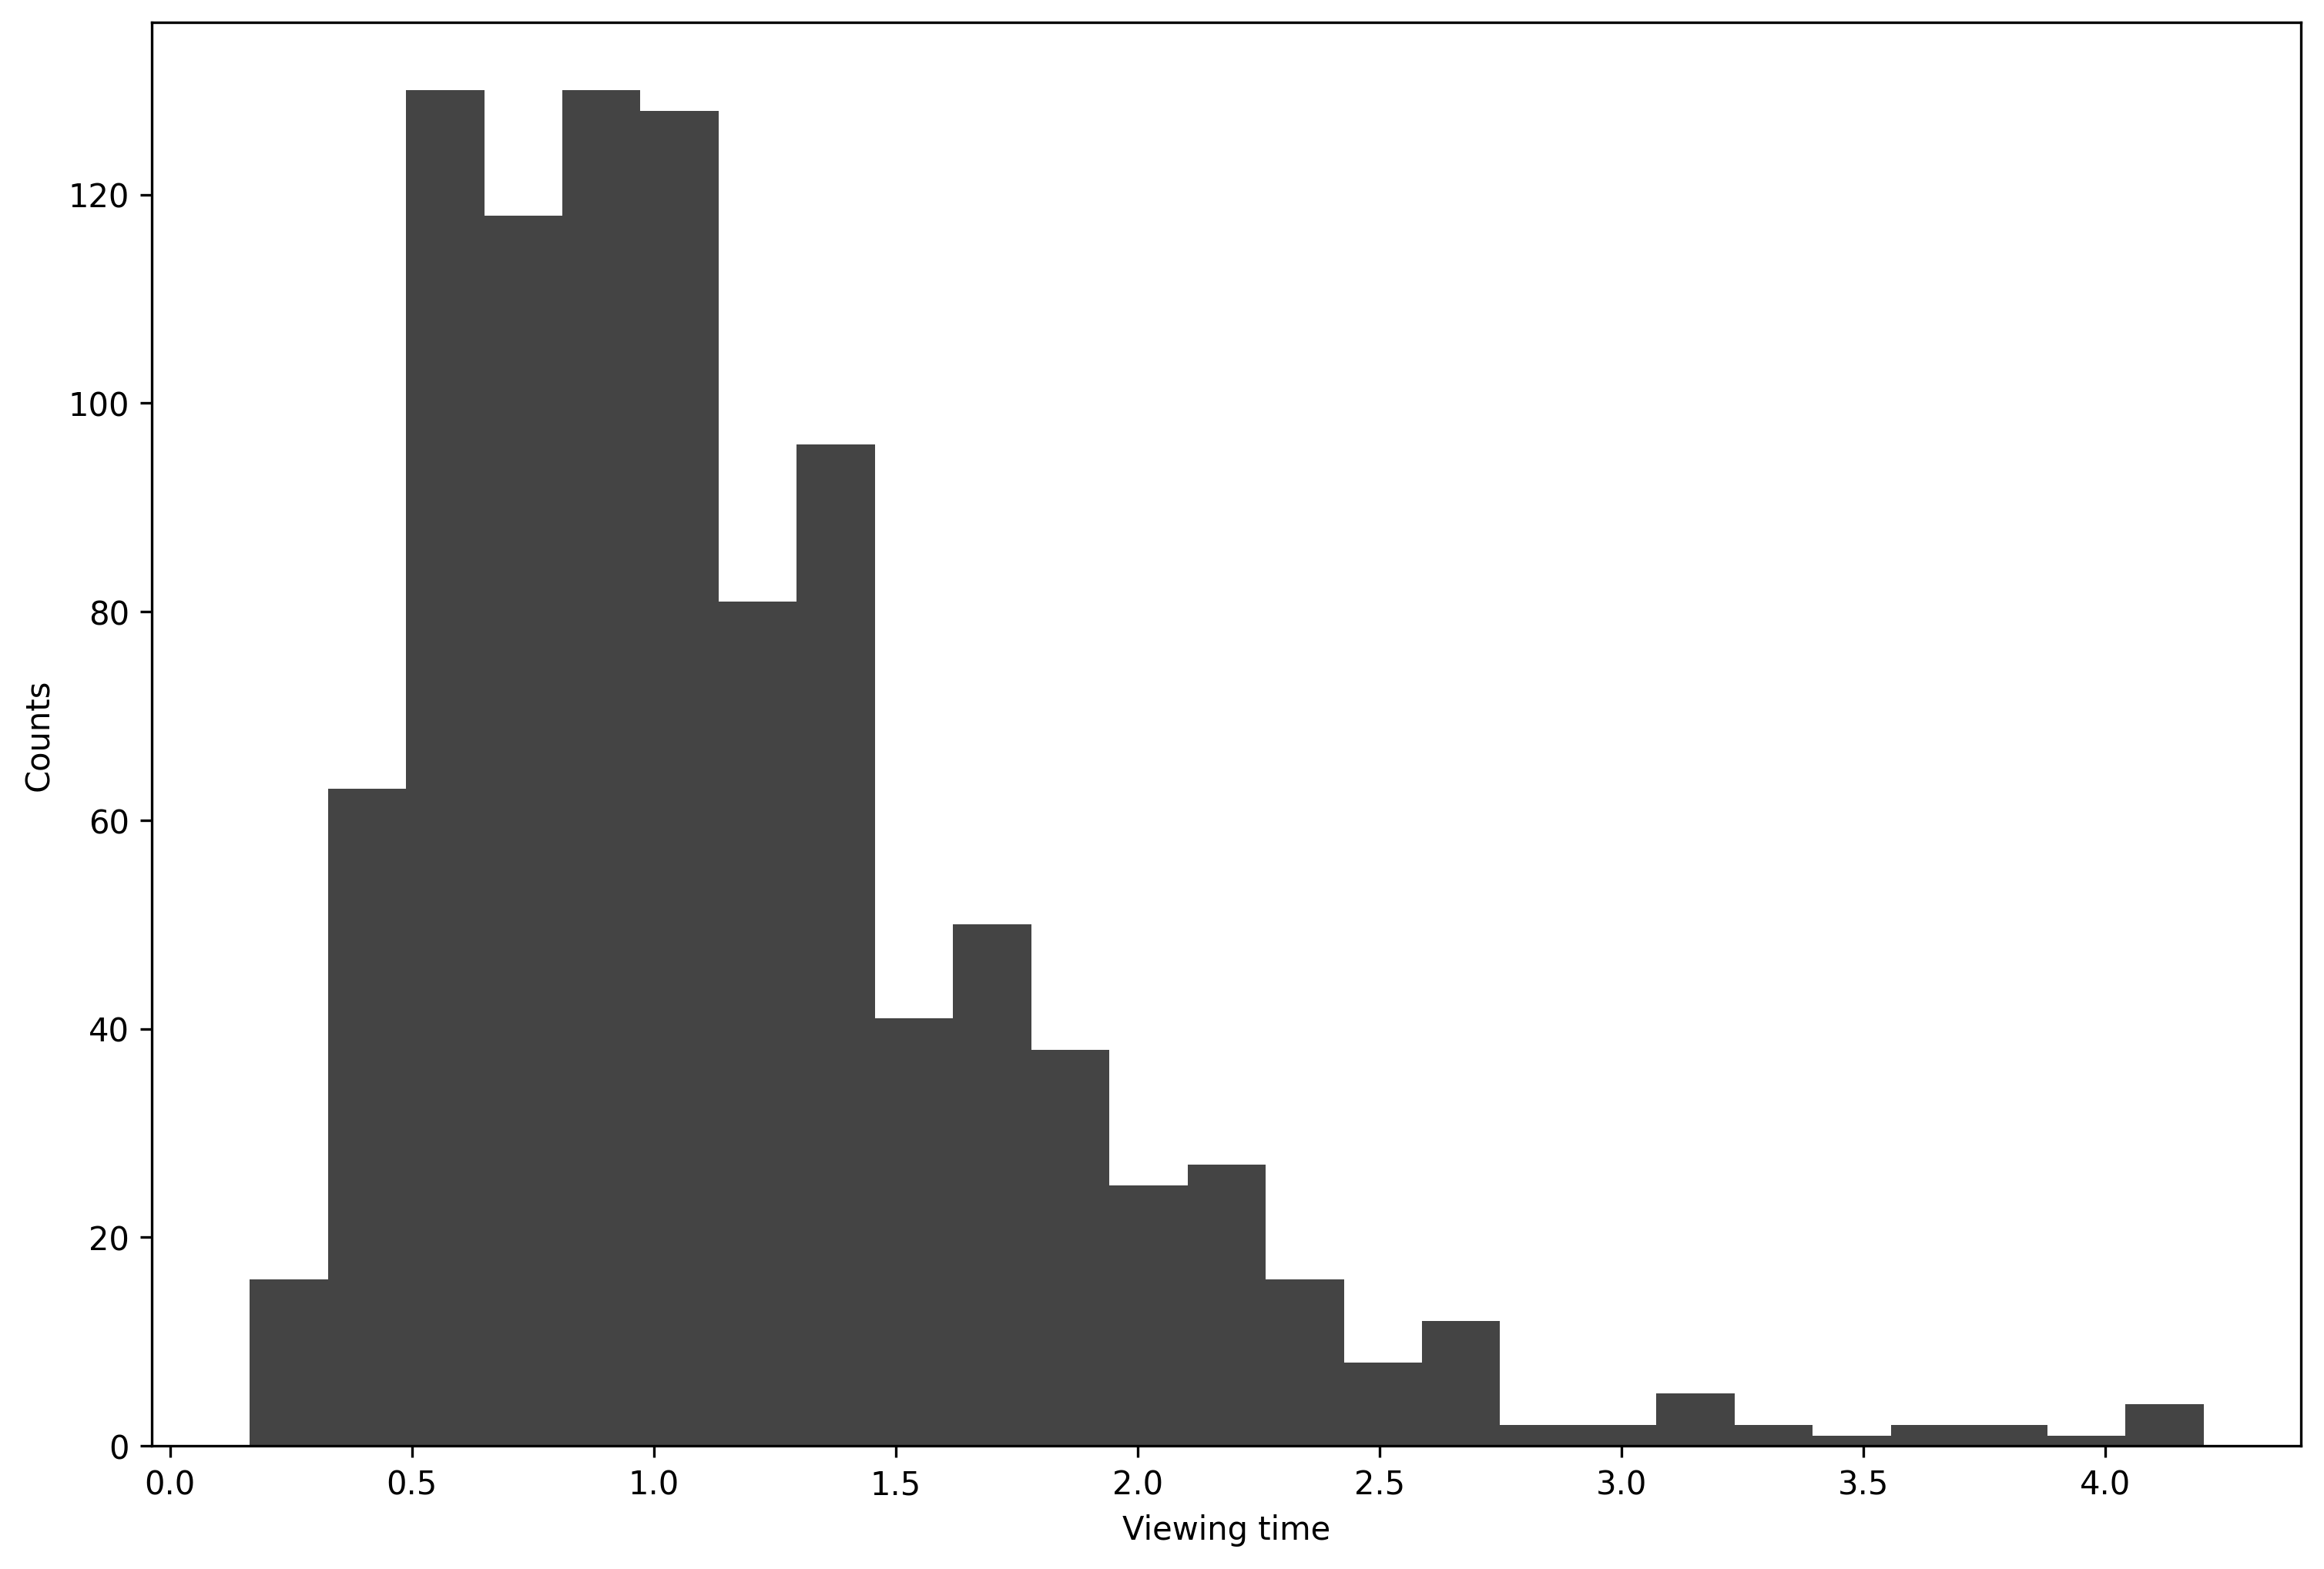

In [5]:
np.random.seed(17)
action_weights = np.random.normal(size=(5,))  # action_weights represents black box model,select randomly here
m = [measure_viewing_time(context=np.random.normal(size=(5,)),  # random context features
                          action_weights=action_weights)        # action weights from black box
                          for _ in range(1000)] # 5 random features for 1000 users
plt.figure(figsize=(12,8))
plt.hist(m, 25, color=e4e.color_1)
plt.xlabel('Viewing time')
plt.ylabel('Counts')
plt.show()

#### Fit the prediction model

In [6]:
# A logged sample for each user (context)
class Sample:                       # production system logs one Sample for every user interaction event
    def __init__(self, context, action, reward):
        self.context = context      # context is ndarray of features describing a user
        self.action = action        # action is an index to the displayed post
        self.reward = reward        # reward is the viewing time

In [7]:
# Collect logs for each action (post)
def collect_logs_by_action(num_actions, logs):  # sorts samples into buckes indexed by sample.action
    samples_y = [[] for _ in range(num_actions)]    # viewing times of samples for a single post
    samples_x = [[] for _ in range(num_actions)]    # users of samples for a single post
    for sample in logs:  # for each log object, add viewing time and user features for chosen post in object
        samples_y[sample.action].append(sample.reward)  # store the reward in the list at action index of y
        samples_x[sample.action].append(sample.context) # store the context in the list at action index of x
    return samples_y, samples_x     # viewing times for each post and user features for each post

In [8]:
# Build a model for each action (post) if x is a vector
def build_models(num_features, samples_y, samples_x): # samples_y, samples_x are lists containing list
    betas = []
    ngood =0
    nbad = 0
    for y,x in zip(samples_y, samples_x):  # loop through viewing times and user features for each action
        y = np.array(y)         # viewing times for current action
        x = np.array(x)         # user features for each action
        if len(y) > 0:          # we need samples to fit
            beta = np.linalg.pinv(x.T@x) @ x.T@y    # perform linear regression using pseudoinverse
            ngood += 1
        else:
            beta = np.zeros(shape=(num_features,))  # if no samples, result is 0's
            nbad += 1
        betas.append(beta)      # learned weight for predicting viewing times for current action 
    return betas                # return list of lists of action model parameters for each action

#### Add the the decision-making component

In [9]:
# Complete contexual bandit
class RecommenderGreedy:
    def __init__(self, num_features, num_actions):  # initialize with context feature size and actions size
        self._num_features = num_features
        self._num_actions = num_actions 

    def reset(self):                        # initialize betas to random values
     
        self._betas = [np.random.normal(size=(self._num_features,)) # cold start weights by randomization
                       for _ in range(self._num_actions)] # initialize weight attribute 
        
        
    def fit_offline(self, logs):            # fit model offline to logged samples
        samples_y, samples_x = collect_logs_by_action(self._num_actions, # X,y are list of lists
                                                      logs) # sort logs into X,y for each action 
        self._betas = build_models(self._num_features,      # linear regression weights for each action
                                   samples_y, samples_x)    # update weight attribute, list of lists

    def policy(self, context):              # decide, online, which post to display to specified context
        viewing_max = -np.inf               # initialize at negative infinity for comparison
        for action in range(self._num_actions):             # for each post that could be shown to context
            viewing_hat = context @ self._betas[action]     # estimate viewing time
            if viewing_hat > viewing_max:                   # track post with maximum estimated viewing time
                action_best = action        # update the post with the highest predicted viewing time
                viewing_max = viewing_hat   # update the highest predicted viewing time seen so far
        return action_best

#### Run and evaluate the greedy recommender

We run our experiments for a couple of days. On each day, we decide the number of users that constitute a sample, and we repeat our experiment a couple of times due to variation. Here we decide that 100 users constitute a sample and we repeat our experiment a couple of times. Our user features are one-hot encoded 5 feature vectors.On day 1, we choose random weights for each post (cold start), and for each random user (to avoid bias), we predict the viewing times with the weights and select the post with the highest predicted viewing time, serve that post to the user, and measure the actual viewing time. We store each event in a Sample object with user features, chosen post, and measured viewing time. We also track the total measured viewing time to calculate the average viewing time for all 100 users. At the end of the day, we take the event objects, separate them into X,y ie user features vs viewing time for each post, and learn new linear regression weights for each post. This means we end the day with the average viewing time on day 1, the data captured on day 1, and the updated weights from day 1. On day 2 we do the same thing as day 1 only this time, we use the updated weights learned on day 1. We keep doing this for a 14 day period for our first set of data. We rinse and repeat this 10 more times, so that we have 10 sets of data and calculate the average (aggregate) viewing time and standard error for day 1 to day 14 using the 10 sets of data. We plot the aggregated time, and standard error from day 1 to day 14. The results show that the average viewing time steadily increases as the days go by. We calculate the asymptote viewing time with the aggregate viewing times from day 5 to day 14 by taking an average (by this time, our models had a good idea how to match users up with the posts).

In [10]:
def log_production_data(action_weights, recommender):
    logs = []
    total_viewing_time = 0
    num_decisions = 100
    for _ in range(num_decisions):   # simulate 100 different users and their viewing times on current day
        context = np.random.randint(2, size=(len(action_weights),))  # features describing a random user
        context[0] = 1  # first feature is just a constant/ intercept term / offset
        action = recommender.policy(context)    # choose best post with policy (decision making component)
        viewing_time = measure_viewing_time(context=context,    # measure viewing time of chosen post for user
                                            action_weights=action_weights[:, action]) 
        logs.append( Sample(context, action, viewing_time)) # log the event, user, post id, viewing time
        total_viewing_time += viewing_time      # track total viewing time
    avg_viewing_time = (total_viewing_time) / num_decisions     # aggregate viewing time from total time
    return avg_viewing_time, logs   # aggregate viewing times and event objects

In [11]:
def run_experiment_sequence(action_weights, num_actions, recommender):
    num_days = 14                               # experiment held for 14 days for each set of users
    num_features = action_weights.shape[1]      # number of features used to describe a user
    avg_viewing_times = []                      # average viewing times of users for each day
    all_logs = []                               # data for each day
    recommender.reset()                         # initialize weights to random values on each run of users
    for _ in range(num_days):                   # get measurements for num_days here 14 days
        avg_viewing_time, logs = log_production_data(action_weights, recommender) # get the data
        avg_viewing_times.append(avg_viewing_time)  # average viewing time for all users for current day
        all_logs.extend(logs)   # extend all_logs by adding log objects for all users from current day      
        recommender.fit_offline(all_logs)       # use data from current day, to retrain the offline model

    avg_viewing_times = np.array(avg_viewing_times)
    return avg_viewing_times

In [12]:
def run_sequences(action_weights, num_actions, recommender):
    avg_viewing_times = []
    num_runs = 10               # sets of users ie concurrent num_runs groups of users for all days
    for _ in range(num_runs): # run experiement for num_runs customers to get aggregate measurements
        avg_viewing_times.append(run_experiment_sequence(action_weights, num_actions, recommender))
    avg_viewing_times = np.array(avg_viewing_times) # convert to ndarray
    mean = avg_viewing_times.mean(axis=0)           # aggregate measurement of all runs per day
    se = avg_viewing_times.std(axis=0)/np.sqrt(num_runs)    # standard error of aggregate measurement
    return mean, se         # aggregate measurement of viewing times per day and standard error

In [13]:
num_features = 5        # number of features used to describe features (user)
num_actions = 30        # number of actions (posts) to choose from

np.random.seed(17)
action_weights = np.random.normal(size=(num_features, num_actions))     # initial action weights shape (5,30)
recommender = RecommenderGreedy(num_features, num_actions) # create object,store num feature/actions attributes
mean, se = run_sequences(action_weights, num_actions, recommender)  # get mean, se for different days
betas_g = recommender._betas

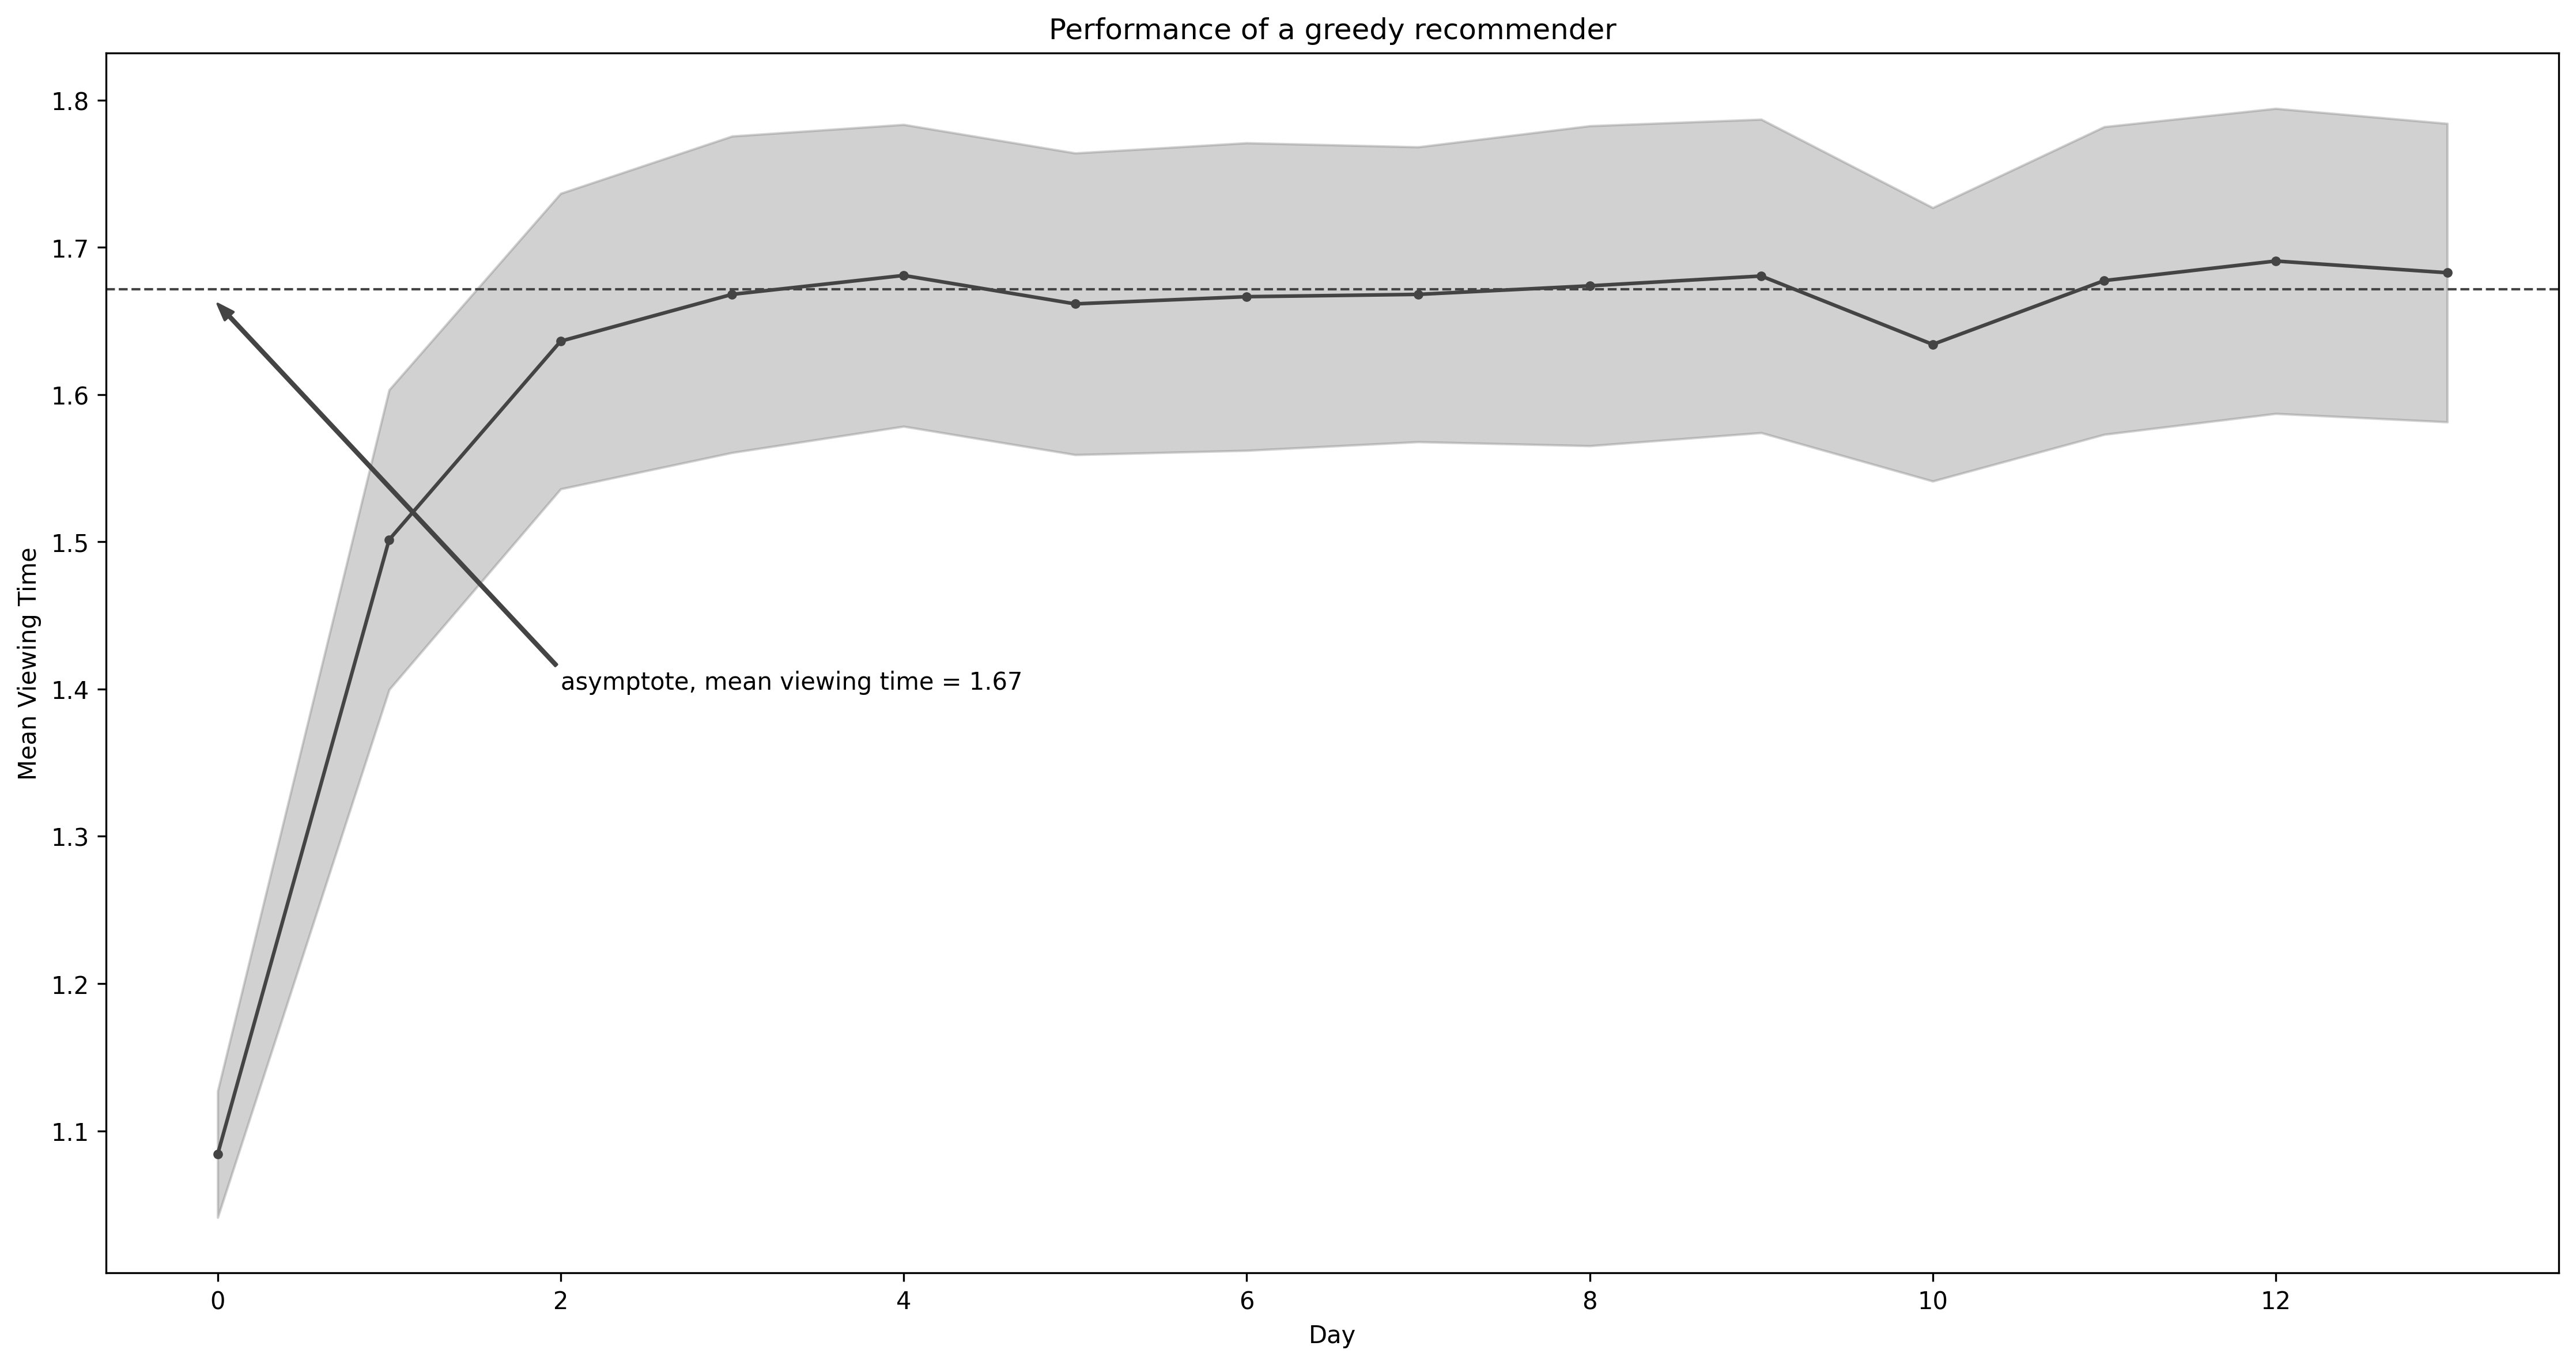

In [14]:
plt.figure(figsize=(15,8))
plt.plot(mean, '.-', color=e4e.color_1)
plt.fill_between(np.arange(len(mean)),
                 mean - se,
                 mean + se,
                 color=e4e.color_2,
                 alpha=e4e.alpha_err,
                 linewidth=1)
asymp = mean[4:].mean()
e4e.horizontal_line(asymp, e4e.color_1)

plt.annotate(f"asymptote, mean viewing time = {asymp:.2f}", xy=[0, asymp-0.01],
             xytext=[2, 1.4],
             arrowprops=e4e.arrow_props)
plt.xlabel('Day')
plt.ylabel('Mean Viewing Time')
plt.title('Performance of a greedy recommender')
plt.tight_layout()
plt.show()

### Explore actions with epsilon-greedy

The constant exploitation of the gredy contexual bandit algorithm, makes it such that, if a user is hasnt been shown a particular action in the past, its will likely not be shown that post in the future. This is because the model for that action, will never get to learn from a user who hasnt been recommended that action. In other words, users keep getting shown more of the same but never being introduced to new actions. 

Epsilon greedy's fix to this issue is to update the recommender's policy from a pure exploitation policy to an exploration-exploitation policy. The policy assigns a random recommendation with probability epsilon, and recommends a greedy (exploitation) recommendation with probaility 1- epslilon. This allows a more diverse set of data for the actions models to train on, as users are given a chance of seeing an action even if its not the one they would have chosen. The end result is that like the greedy contexual bandit, the average viewing time increases as they days go on, until they reach an asymptotic level, when models would have adequately learned from users. The influence of exploration however, increases the average viewing time for the epsilon greedy contexual bandit when compared to the pure exploitation of the greedy contexual bandits.

In [15]:
# Mising counterfactuals degrade predictions
'''data for action = 1'''
contexts = [[1,0,0],
            [0,1,0],
            [0,0,1]
            ]                                       # features of users who were shown action 1

rewards = [0.6, 0.9, 1.3]                           # viewing times of users who were shown action 1
x = np.array(contexts)
y = np.array(rewards)
beta_1 = np.linalg.pinv(x.T@x)@(x.T@y)              # model produces with all 3 user information
beta_1

array([0.6, 0.9, 1.3])

In [16]:
'''Assuming context user 3 was not shown action = 1, then 
it would be missing from data for action = 1'''
contexts = [[1,0,0],
            [0,1,0],
            ]                       # features of users who were shown action 1

rewards = [0.6, 0.9]                # viewing times of users who were shown action 1
x = np.array(contexts)
y = np.array(rewards)
beta_2 = np.linalg.pinv(x.T@x)@(x.T@y)              # model learned without user 3 information
beta_2

array([0.6, 0.9, 0. ])

In [17]:
np.array([0,0,1]) @ beta_2  # without conterfactual, model predicts 0 for context user 3

0.0

In [18]:
# Epsilon-greedy recommender
class RecommenderEpsilonGreedy:
    def __init__(self, num_features, num_actions, epsilon=0.1):
        self._num_features = num_features 
        self._num_actions = num_actions 
        self._epsilon = epsilon            # epsilon-greedy is parameterized by epsilon (prob of exploration)

    def reset(self):
        self._betas = [np.random.normal(size=(self._num_features,))
                       for _ in range(self._num_actions)]
        
    def fit_offline(self, logs):
        samples_y, samples_x = collect_logs_by_action(num_actions, logs)
        self._betas = build_models(self._num_features, samples_y, samples_x) # update betas after training

    def policy(self, context):  # exploration is added to the policy
        viewing_max = -np.inf   # using for loop for a max, so initialize at negative infinity
        if np.random.uniform(0,1) < self._epsilon:  # explore with probability p(epsilon)
            action_best = np.random.randint(0, self._num_actions)  # show a random action
        else:                   # exploitation, take the best again
            for action in range(self._num_actions): # exploit with probability p(1-epsilon)
                viewing_hat = context @ self._betas[action] # read updated betas, after last traiing f_o()
                if viewing_hat > viewing_max:
                    action_best = action
                    viewing_max = viewing_hat 
        return action_best

In [19]:
np.random.seed(17)
recommender = RecommenderEpsilonGreedy(num_features, num_actions, epsilon=0.1)
mean_eps, se_eps = run_sequences(action_weights, num_actions, recommender)
betas_eg = recommender._betas

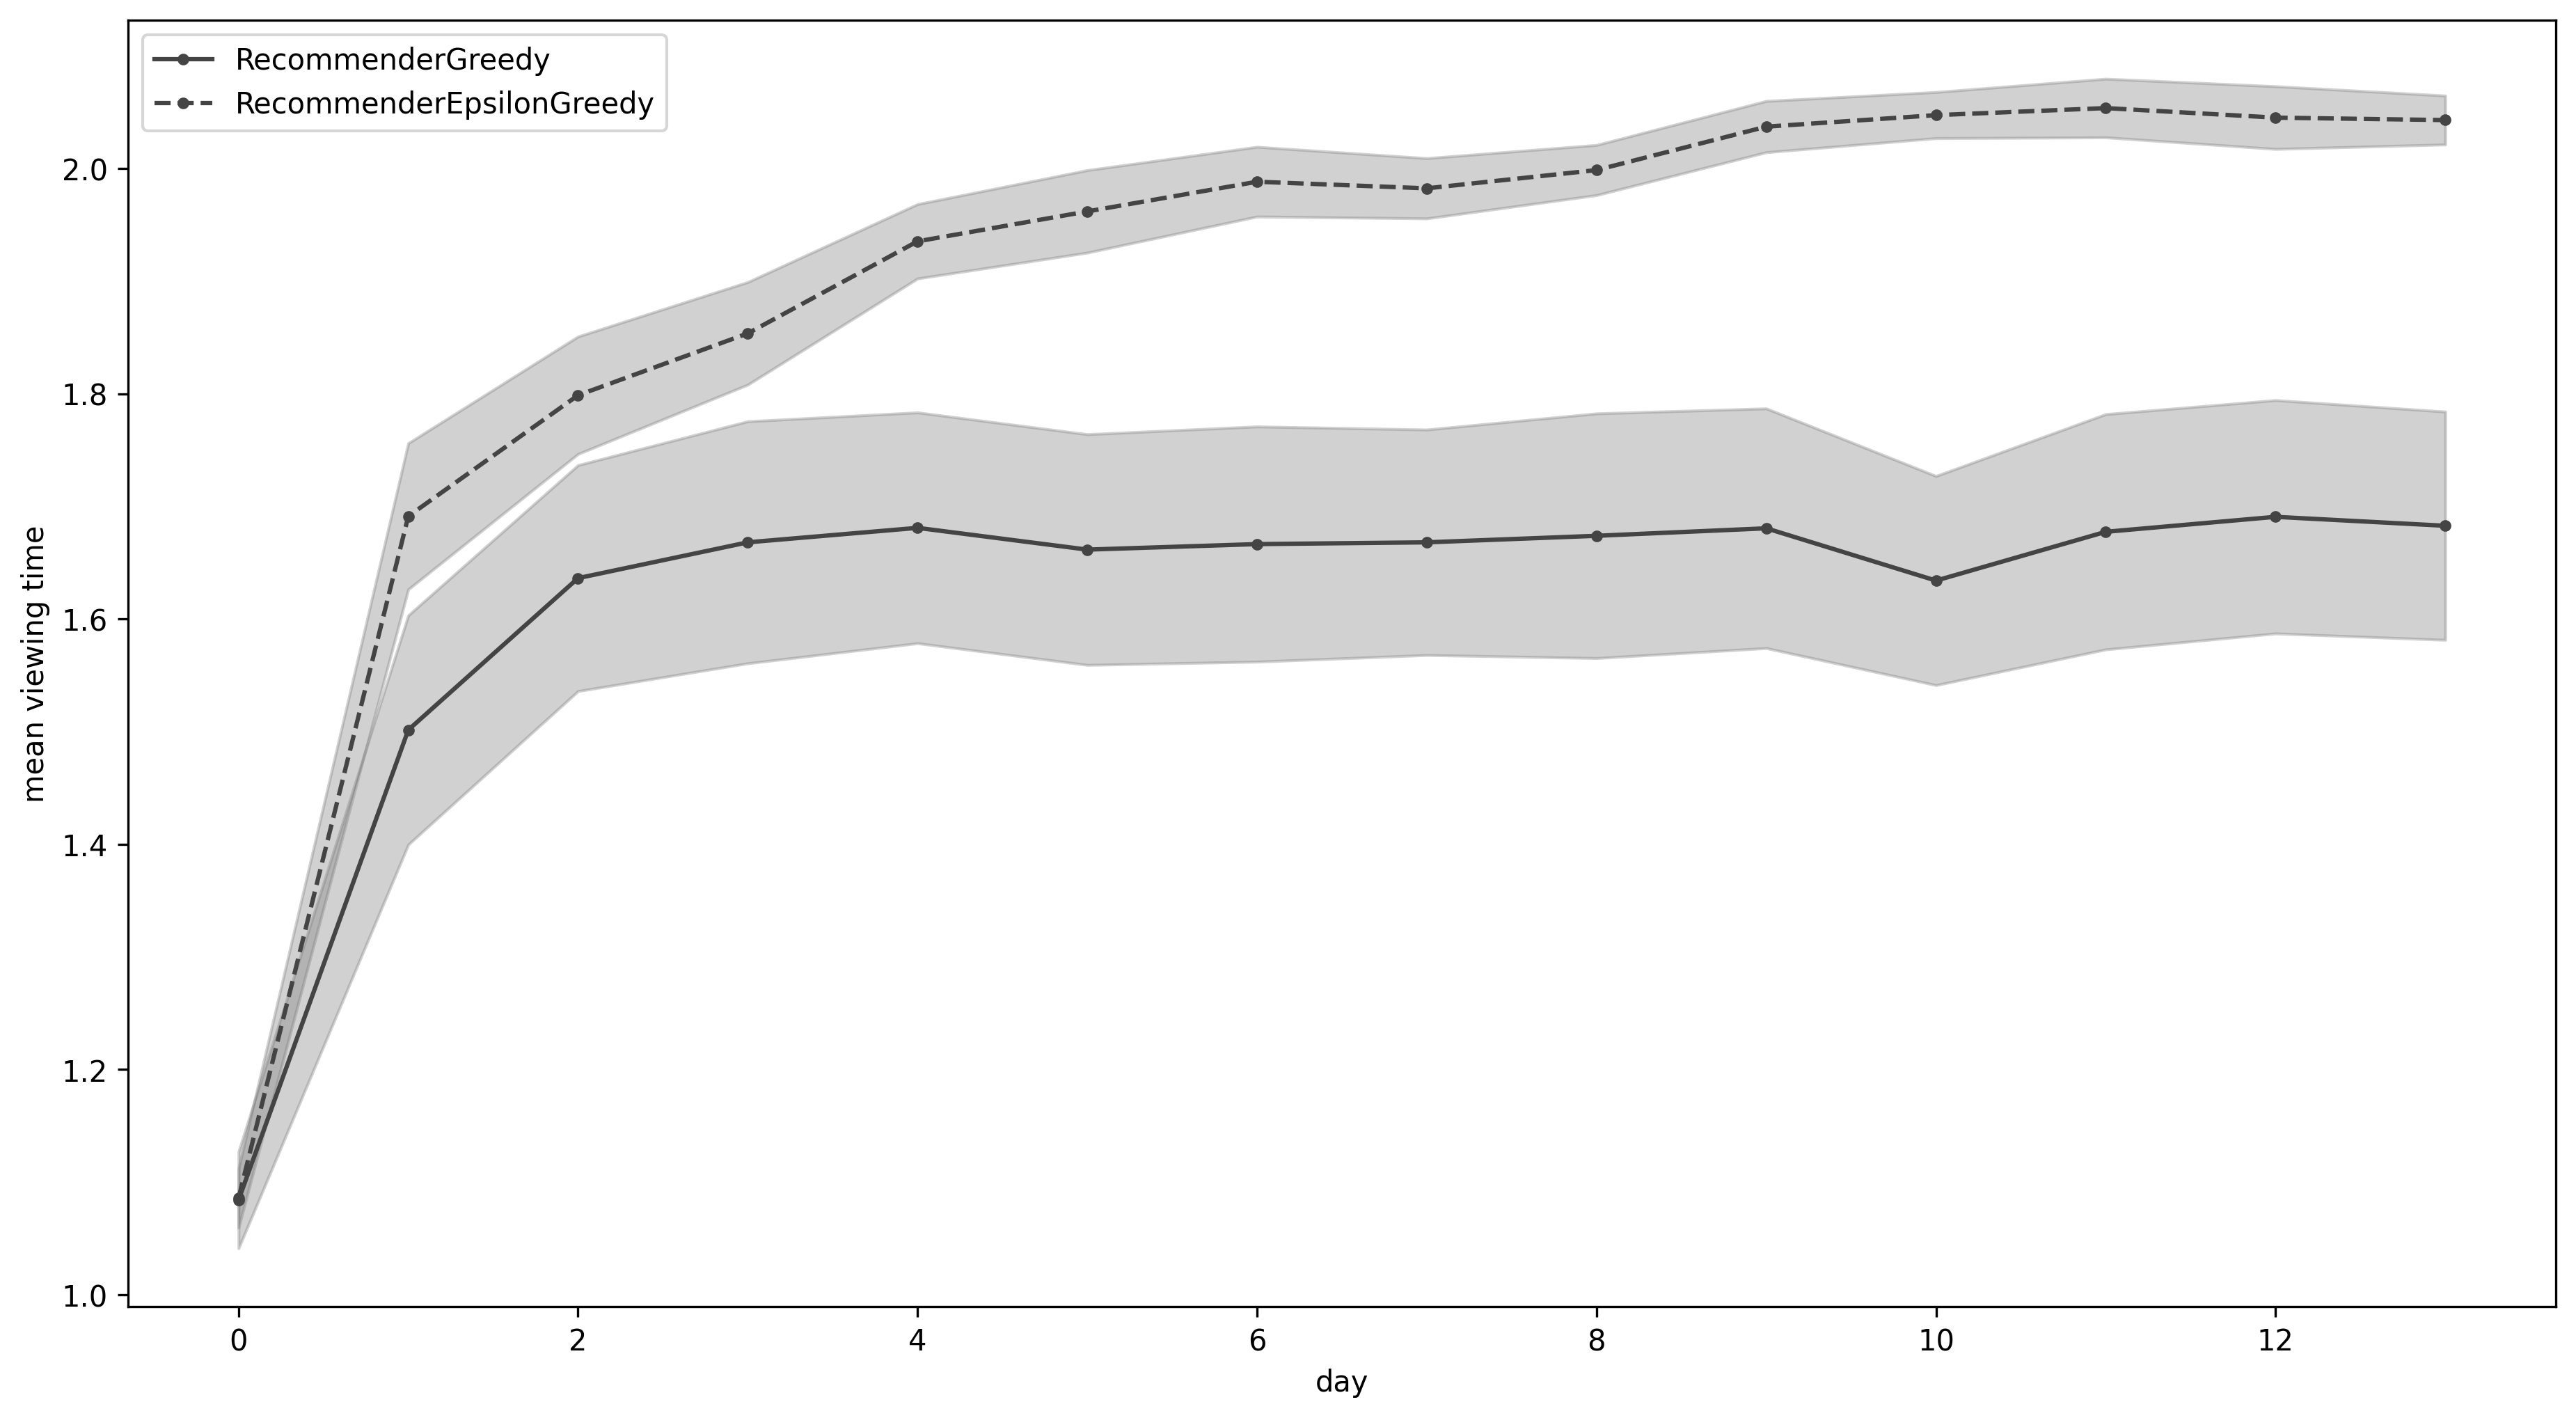

In [20]:
plt.figure(figsize=(15,8))
plt.plot(mean, '.-', color=e4e.color_1)
plt.plot(mean_eps, '.--', color=e4e.color_1)

plt.fill_between(np.arange(len(mean)),
                 mean - se,
                 mean + se,
                 color=e4e.color_2, alpha=e4e.alpha_err, linewidth=1)

plt.fill_between(np.arange(len(mean_eps)),
                 mean_eps - se_eps,
                 mean_eps + se_eps,
                 color=e4e.color_2, alpha=e4e.alpha_err, linewidth=1)

plt.legend(['RecommenderGreedy', 'RecommenderEpsilonGreedy'])
plt.xlabel('day')
plt.ylabel('mean viewing time')
plt.show()

### Explore parameters with Thompson sampling

In the multi-armed bandit problem, thompson sampling improves on epsilon-greedy by replacing the exploration-exploration paradigm with a probability of best arm. Similarly thompson sampling contexual bandit can be an improvement on epsilon greedy contexual bandit. Thompson sampling can use bootstrapping or random probability matching to achieve a mixture of exploration-exploitation since every action's model has a good blend of users because each user is shown each action with a probability equal to the probability of being the best arm.

With online bootstrap, we build multiple models with bootstrap samples. The first thing we do when fit_online() is called with the collected data logs from the previous day is to segment them into data for the different action models using collect_logs_by_action(). In the greedy and epsilon-greedy contextual bandits, we build a model for each action. In thompson sampling with online bootstrapping, we build an ensemble for each action using bootstrapped samples from the measurement data for each action. The number of models in the ensemble is stored as the number of bootstrap samples as we bootstrap samples for each model in the ensemble. 

For each round of the ensemble model building, we bootstrap samples for each action, train linear regression models and for each action and store the the weights of the linear model for each action. Then for the policy, we randomly choose one of the ensembles, and for that set, we use the learned weights to to make predictions of the expected reward (viewing time) for each context (user), and use a greedy algorithm to choose the action. Since we have multiple models in the ensemble, each action has a chance to be the best model in a bootstrap model set and thus be shown to the context (user). This also means that when we reset the model, for each action, we need as many random model weights as there are bootstrap samples to be taken later.

The graph below shows that the thompson sampling contextual bandit with online sampling beats both the greedy contextual bandit and the epsilon greedy contexual bandit in terms of the asymptotic reward (viewing time). Like both the greedy contexual bandit and epsilon greedy contexual bandit, the thompson sampling contexual bandit with online bootstrap shows a steady increase in reward with day ie the models get better at picking the actions for each type of customer.

One difference between thompson sampling contexual bandit is that the thompson sampling allows exploration of model parameters while epsilon greedy is exploration over actions. In thompson sampling, for any context, we are constructing a distribution of rewards for each action and randomly selecting from the distribution for each action. 

In [21]:
# simulating measurements from real measurements
np.random.seed(17)
visits = np.array([3 + int(5*np.random.uniform()) for _ in range(100)])     # real measurements, population
i = np.random.randint(len(visits))                      # choose a randoom index for data on visits
visits[i]                                                                   # single measurement data, y

3

In [22]:
# bootstrap sample
i = np.random.randint(len(visits), size=(len(visits),))  # choose randoom indices for data on visits
bs_visits = visits[i]
bs_visits

array([6, 5, 7, 5, 3, 5, 3, 7, 3, 5, 5, 5, 3, 6, 7, 3, 6, 6, 5, 7, 5, 3,
       3, 5, 5, 3, 3, 7, 3, 7, 4, 6, 3, 7, 6, 7, 5, 4, 3, 5, 5, 4, 7, 6,
       3, 5, 3, 3, 5, 3, 3, 6, 7, 3, 6, 7, 4, 6, 3, 6, 6, 7, 7, 7, 7, 6,
       7, 3, 4, 4, 5, 3, 6, 3, 5, 6, 7, 6, 3, 7, 5, 7, 3, 6, 4, 7, 3, 5,
       5, 7, 4, 4, 4, 4, 4, 7, 4, 4, 5, 3])

In [23]:
# bootstrap sample has roughly same summary statistics as real measurements
print(visits.mean(), visits.std())                  # measurement sample mean
print(bs_visits.mean(), bs_visits.std())            # bootstrapped sample mean

5.01 1.4525494828060075
4.95 1.49248115565993


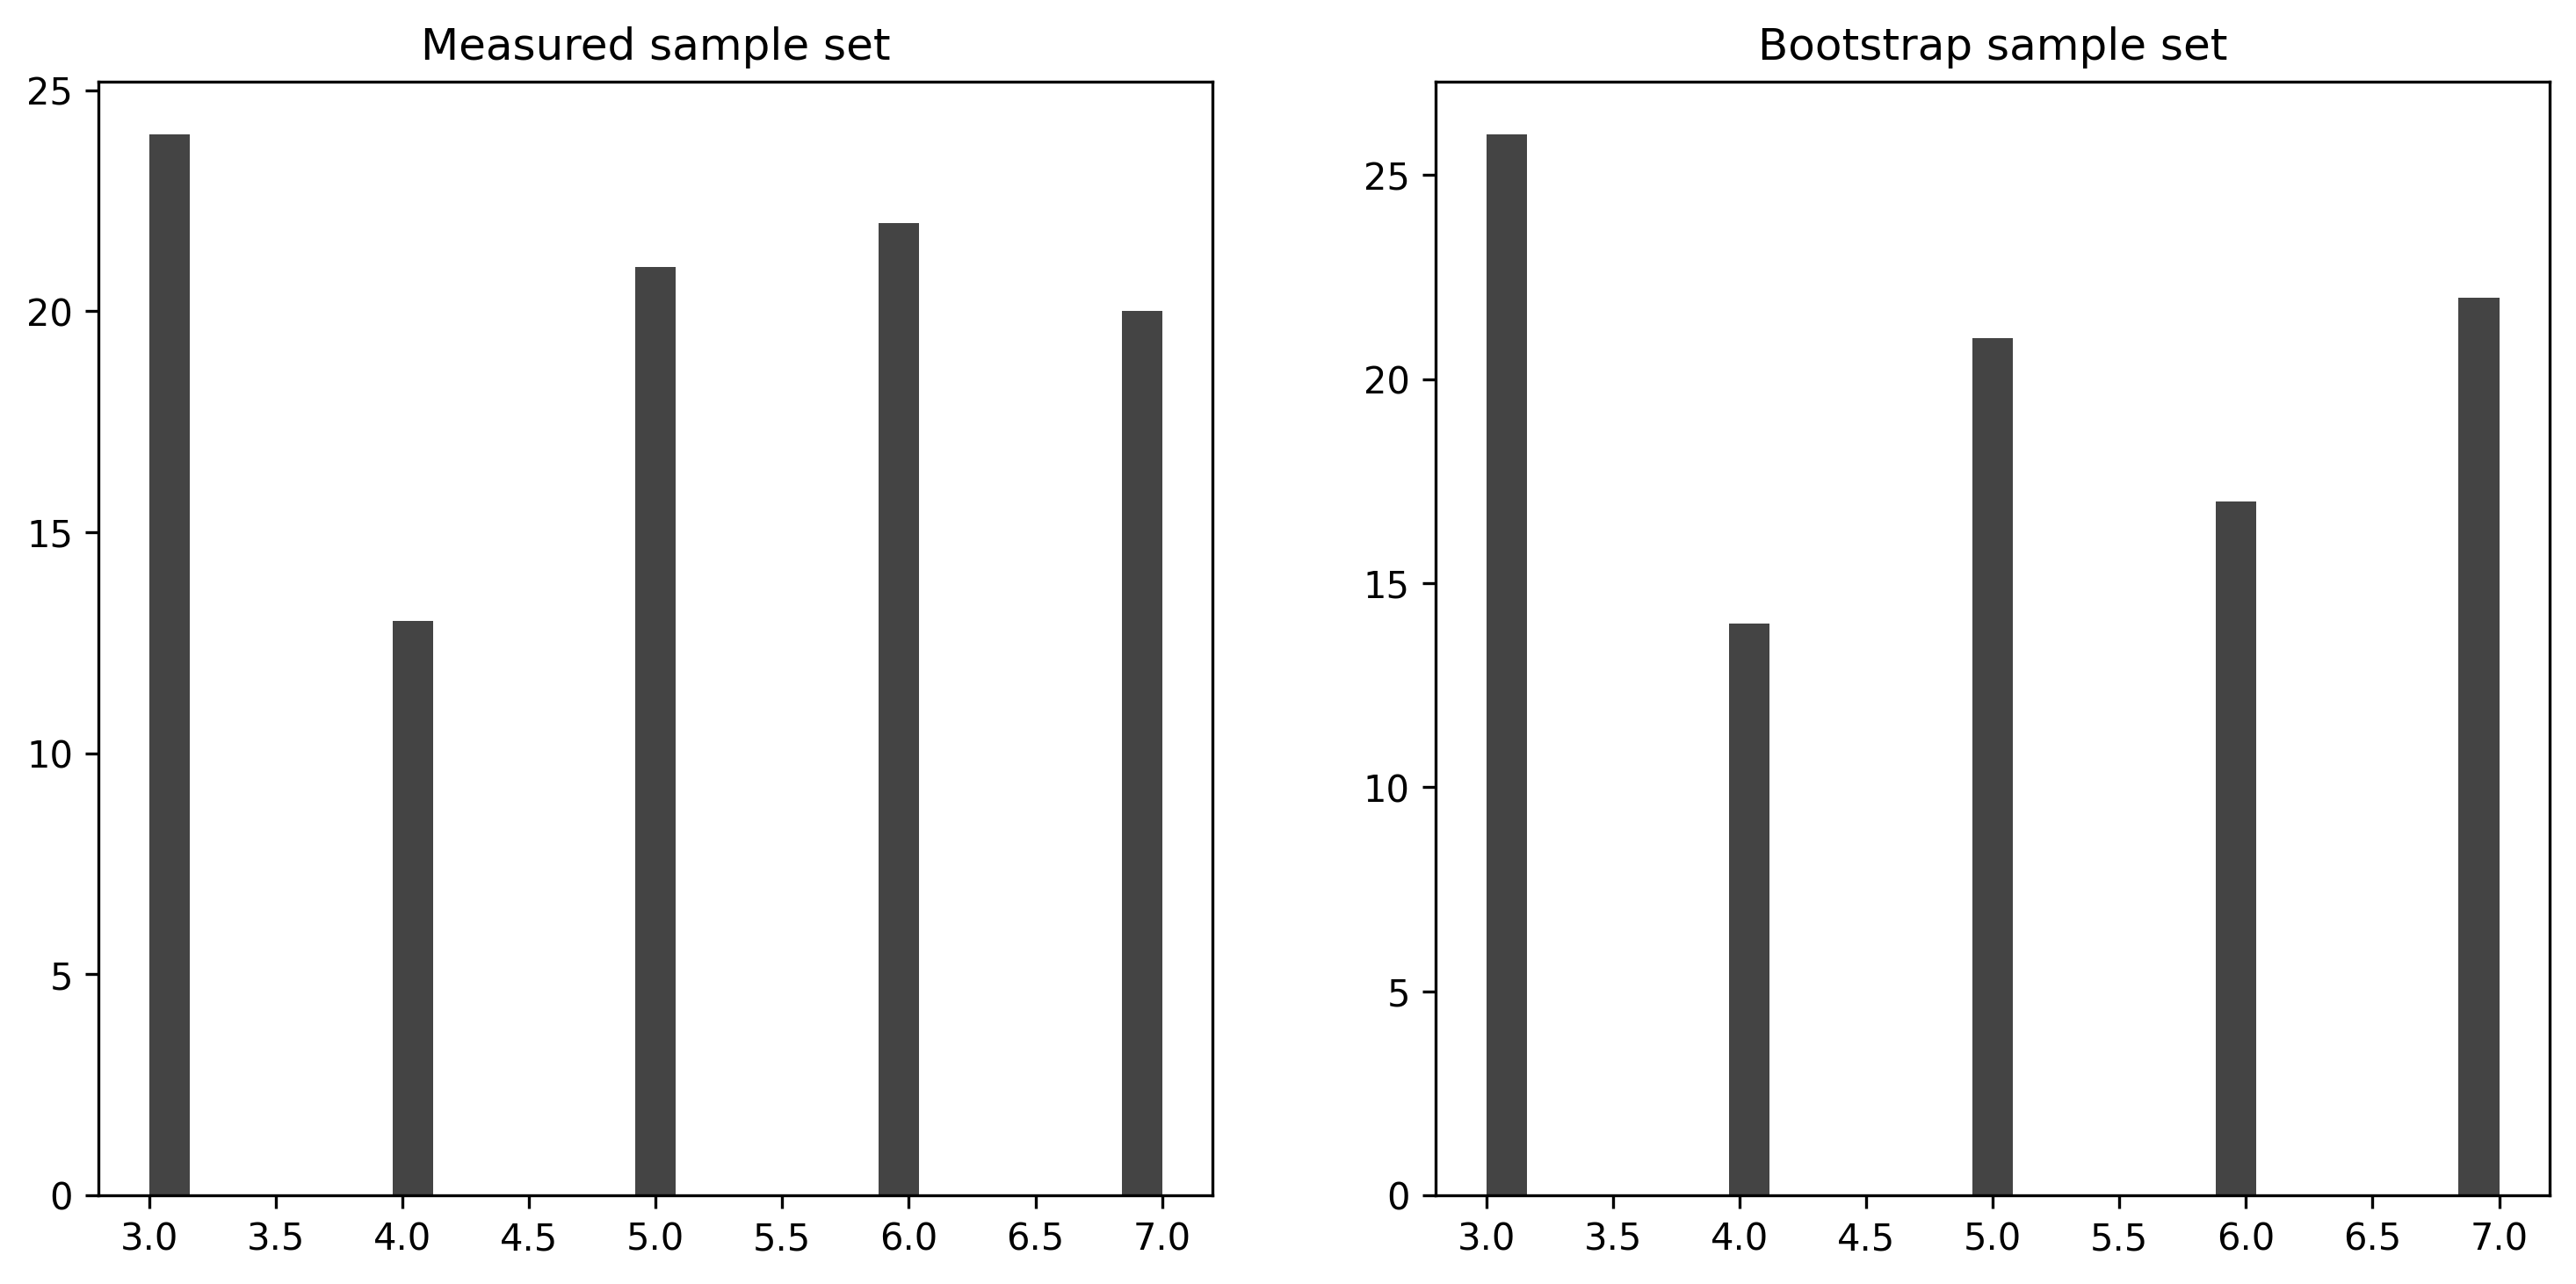

In [24]:
# compare distribution of bootstrap sample to real measurements
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
ax1.hist(visits, 25, color=e4e.color_1)
e4e.aspect_square(ax1)
ax1.set_title('Measured sample set')

ax2.hist(bs_visits, 25, color=e4e.color_1)
e4e.aspect_square(ax2)
ax2.set_title('Bootstrap sample set')

plt.show()

In [25]:
# Thompson sampling recommender
class RecommenderThompsonSampling:
    def __init__(self, num_features, num_actions, num_bs_samples):
        self._num_features = num_features       # number of features describing context
        self._num_actions = num_actions         # we build a model for each action (ensemble)
        self._num_bs_samples = num_bs_samples   # ensemble of num_bs_samples models (with actions sub-models)

    def reset(self):                            
        self._betas = []
        for _ in range(self._num_bs_samples):  # inititalize action betas for each bootstrap sample
            self._betas.append([np.random.normal(size=(num_features,))  # random weights for each ensemble model
                                for _ in range(self._num_actions)])     # an ensemble model for each action  
    
    def _bs_sample(self, samples_y, samples_x):     # takes as input the sorted data, target from events
        bs_samples_y = []               # bootstrap samples target from each action's events
        bs_samples_x = []                
        for action in range(self._num_actions): # for each action, we get a random bootstrap sample
            y = np.array(samples_y[action])         # access target variable of events that took current action
            x = np.array(samples_x[action])         # access context data of events that took current action
            if len(y) > 0:                          # we need data for bootstrapping
                i = np.random.randint(0, len(y), size=(len(y),))    # same-sized bootstrap sample indices 
                y = y[i]                # target variables of bootstrapped sample
                x = x[i,:]              # context data of bootstrapped sample
            bs_samples_y.append(y)      # store bootstrap sample target variable for current action
            bs_samples_x.append(x)      # store bootstrap sample context data for current action
        return bs_samples_y, bs_samples_x   # return bootstrap samples for each action's model 
    
    def fit_offline(self, logs):
        fit_logs = logs 
        samples_y, samples_x = collect_logs_by_action(num_actions, 
                                                      fit_logs) # target, data for each action's model from logs
        self._betas = []
        for _ in range(self._num_bs_samples):   # ensemble of num_bs_samples model parameters for each action
            bs_samples_y, bs_samples_x = self._bs_sample(samples_y, # take logged data (sorted by action)
                                                         samples_x) # return bootstrap sample for each action
            self._betas.append(build_models(self._num_features, 
                                            bs_samples_y, bs_samples_x)) # bootstrap model parameters
        
    def policy(self, context):          # choose the best action for current context using a random ensemble
        i_beta = np.random.randint(0, len(self._betas))     # bootstrap a set of model parameters for actions
        beta = self._betas[i_beta]      # random set of model parameters for each action from bootstrap samples
        viewing_max = -np.inf                               # negative infinity for comparison
        for action in range(self._num_actions):     # beta contains model parameters for each action
            viewing_hat = context @ beta[action]    # estimated viewing time with current action's model
            if viewing_hat > viewing_max:           # track best business metric (highest target variable)
                action_best = action                # update best action
                viewing_max = viewing_hat   # update estimated business metric / target variable (viewing time)
        return action_best                  # return index of action whose model predicts best business metric

In [26]:
np.random.seed(17)
recommender = RecommenderThompsonSampling(num_features, num_actions, num_bs_samples=30)
mean_ts, se_ts = run_sequences(action_weights, num_actions, recommender)

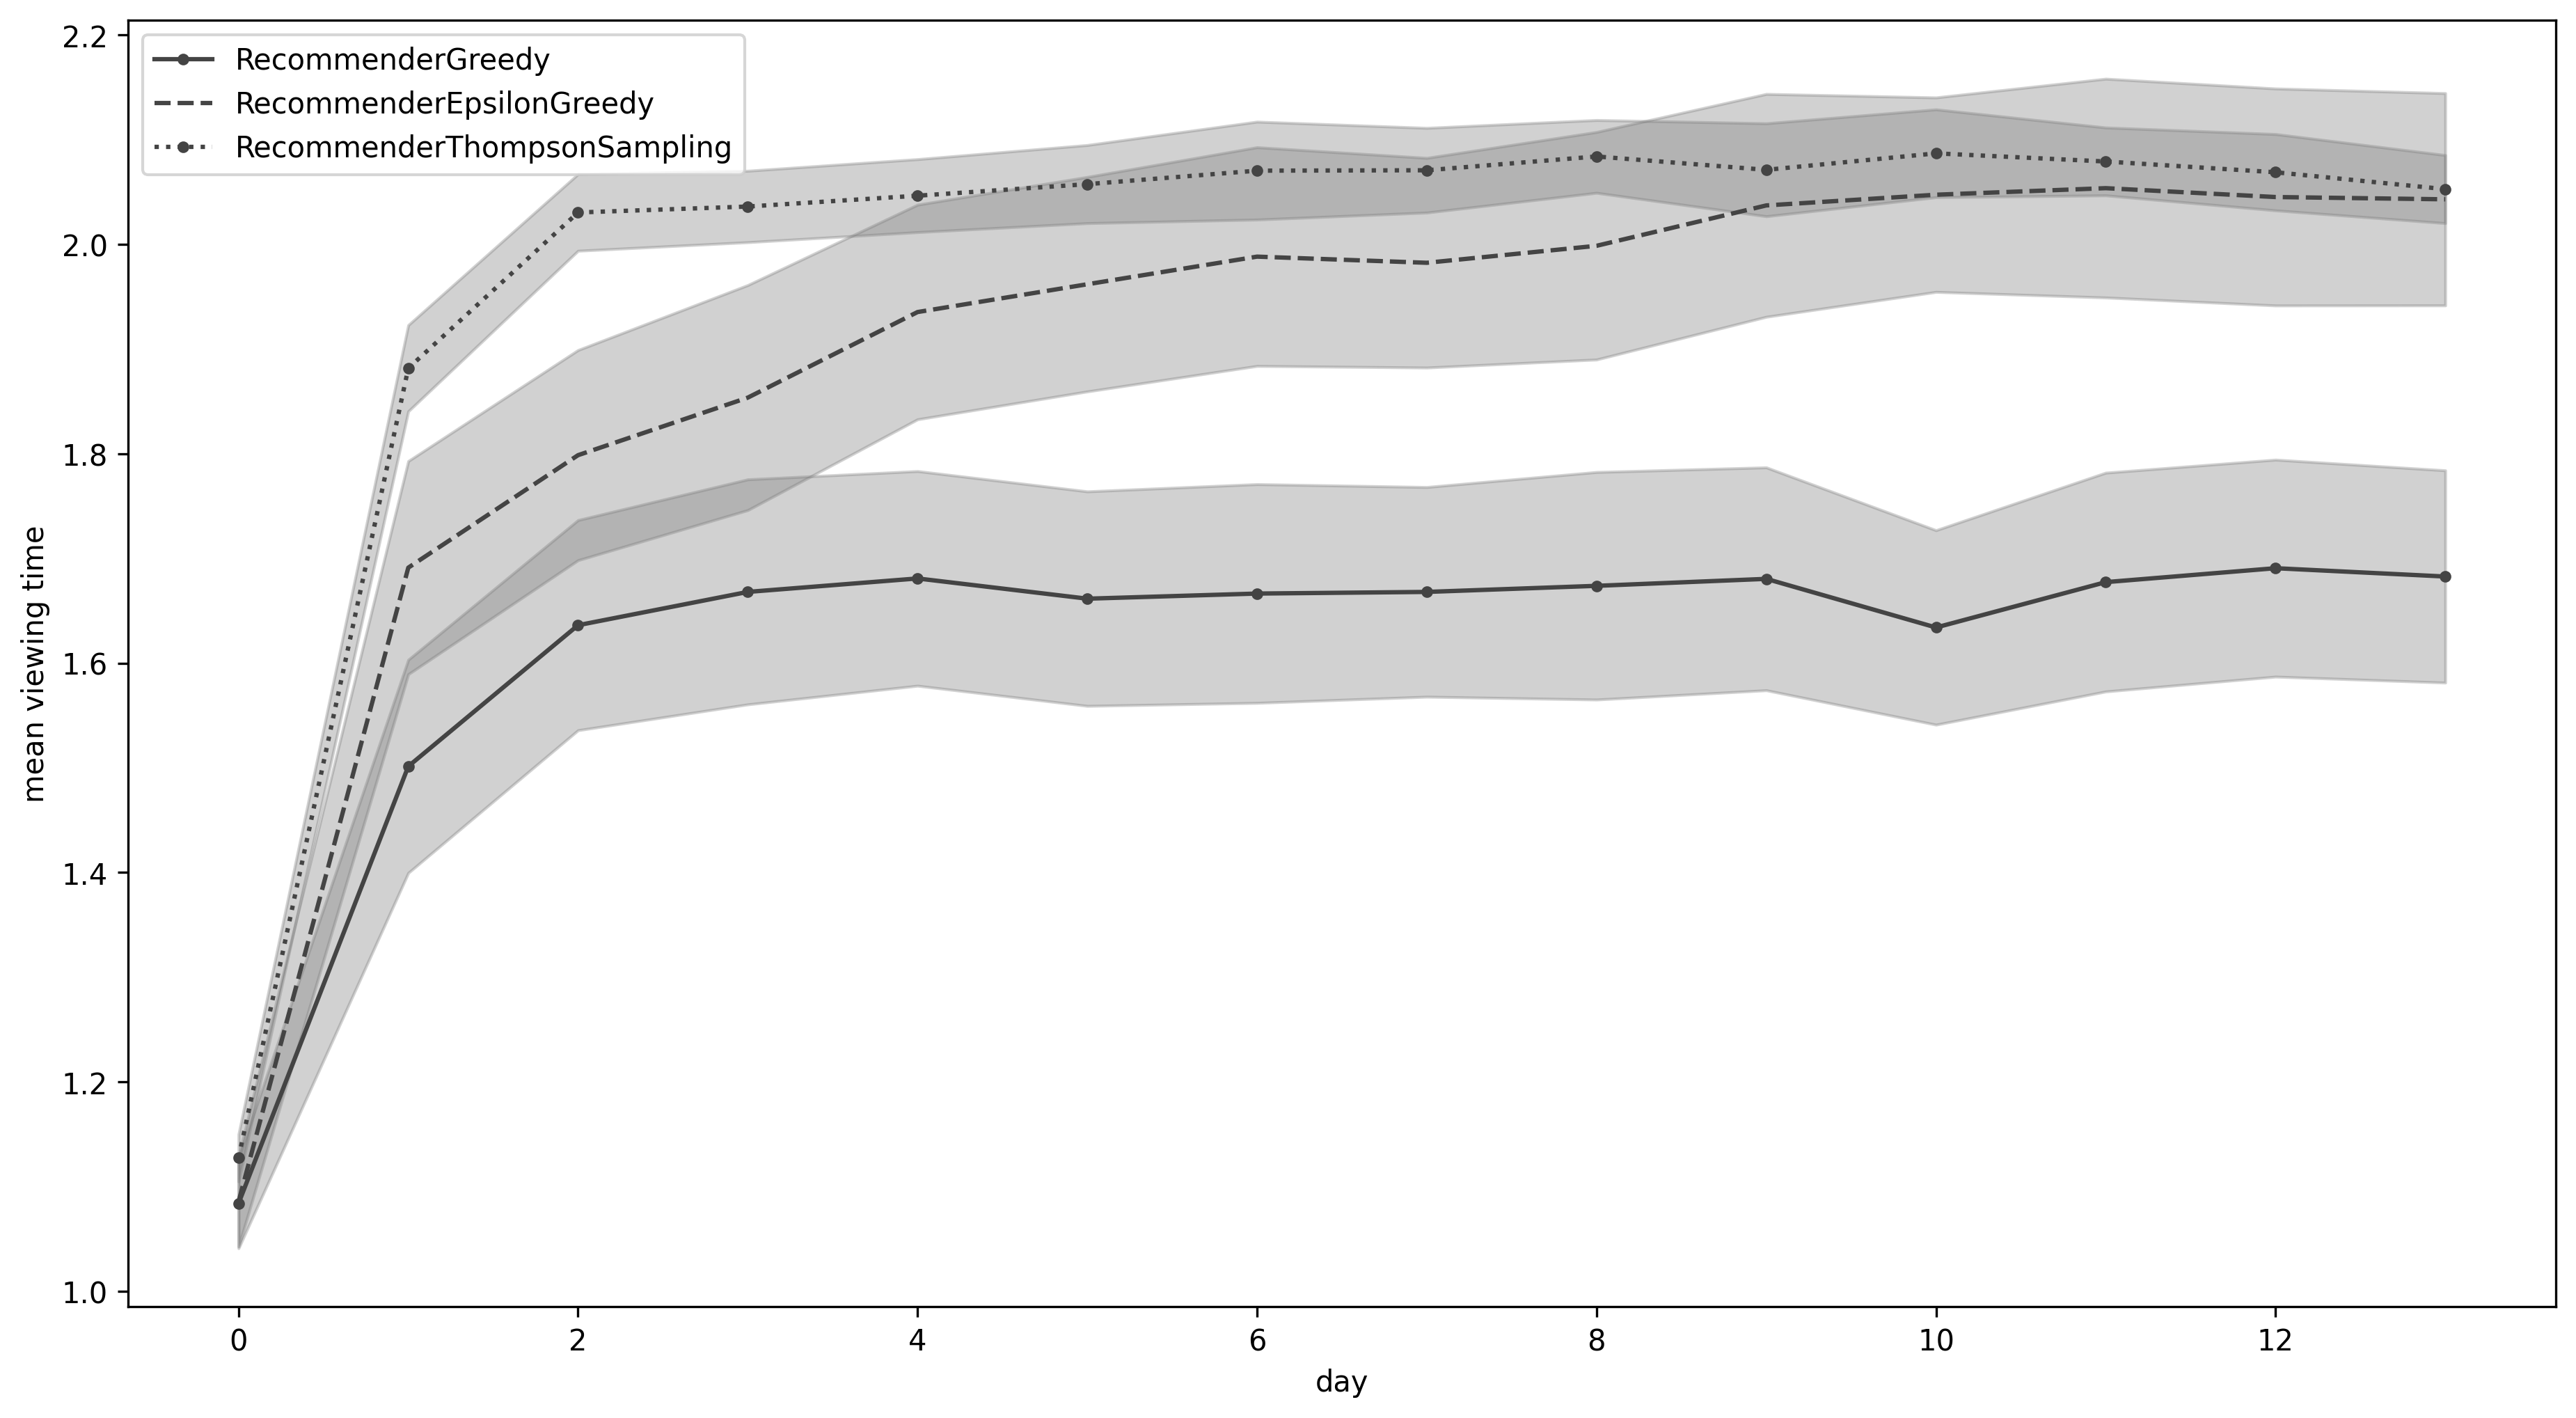

In [27]:
plt.figure(figsize=(15,8))
plt.plot(mean, '.-', color=e4e.color_1)
plt.plot(mean_eps, '--', color=e4e.color_1)
plt.plot(mean_ts, ':.', color=e4e.color_1)

plt.fill_between(np.arange(len(mean)),
                 mean - se,
                 mean + se,
                 color=e4e.color_2,
                 alpha=e4e.alpha_err,
                 linewidth=1)

plt.fill_between(np.arange(len(mean_eps)),
                 mean_eps - se,
                 mean_eps + se,
                 color=e4e.color_2,
                 alpha=e4e.alpha_err,
                 linewidth=1)

plt.fill_between(np.arange(len(mean_eps)),
                 mean_ts - se_ts,
                 mean_ts + se_ts,
                 color=e4e.color_2,
                 alpha=e4e.alpha_err,
                 linewidth=1)

plt.xlabel('day')
plt.ylabel('mean viewing time')
plt.legend(['RecommenderGreedy', 'RecommenderEpsilonGreedy', 'RecommenderThompsonSampling'])
plt.show()


#### Randomized probability matching

To demonstrate how online bootstrap is used to achieve random probability matching the thompson sampling contexual bandit is modified below. Basically, we keep track of the probability of being the best arm whenever an action is chosen and the average probability of being the best per day. In the reset method, we initialize an empty list for probability of being the best and an empty list for mean probability per day. The policy starts of using the randomized weight for the action's ensemble models to estimate the business metric for each context. The models in the ensemble are different based on the bootstrapped data used to build it. Each model in the ensemble is used to choose the action with the highest estimated reward. This means each model in the ensemble will return its own chosen action. From this list of actions, we randomly choose one as the best action. We then calculate the probability that the randomly chosen action is the best action, by counting how many times it occurs in the list of actions returned by the ensemble models.

At the end of the day, the viewing times of the users for the action that was served is saved as logs. The logs are filtered into subsets for different suggested actions. 
For each action, an ensemble of models were built using bootstrapped data to predict the viewing time from context (user) features. In the code, a set of bootstrapped samples were taken containing data for each action's model, and a model was learned for each action and another set of bootstrapped samples are taken again. Before training, the betas attribute is initialized to an empty list, and after training with the current set of bootstrapped samples, the weights were added to the list. The variety introduced by the bootstrapped samples mean that the models built for the same action using different samples will have different weights. After the offline fit to the logged data from the previous day, the policy has to choose which action to show the context. In the policy, we use each model set in the ensemble to greedily choose the action to show to user. Because the model sets have different weights due to different bootstrapped training data, each model set will probably produce a different chosen action. Next, one of the chosen actions is randomly chosen to be shown to the user. The probability that this random choice is the best arm is determined by counting the number of model sets in the ensemble which chose that same action, divided by the size of the ensemble. We track the probability of best arm each time an action is chosen. After a 100 repeated runs, the probability of best arm is averaged for each day across runs and plotted. It shows that the probability keeps increasing after each day.

In [28]:
class RecommenderThompsonSamplingInstrumented:
    def __init__(self, num_features, num_actions, num_bs_samples):
        self._num_features = num_features       # number of features describing a context
        self._num_actions = num_actions         # number of actions = number of regressors in a model set
        self._num_bs_samples = num_bs_samples   # corresponds to number of model sets in ensemble

    def reset(self):
        self._betas = []
        for _ in range(self._num_bs_samples):   # num_bs_samples different model sets in ensemble
            self._betas.append([np.random.normal(size=(num_features,))  # each regressor a (num_feature,) vector
                                for _ in range(self._num_actions)])  # num_actions different regressors
            self._p_best = []               # initialize top p_best(action) list as empty
            self.mean_vs_day = []           # initialize mean p_best(action) list as empty
    
    def _bs_sample(self, samples_y, samples_x):
        bs_samples_y = []                       # bootstrap sample target for each model set
        bs_samples_x = []                       # bootstrap sample data from each model set
        for action in range(self._num_actions): # for each post, since the log data in sorted per action
            y = np.array(samples_y[action])     # select logged data (target) belonging to current action
            x = np.array(samples_x[action])     # select logged data (context) belonging to current action
            if len(y) > 0:                      # we need data for bootstrap, 
                i = np.random.randint(0, len(y), size=(len(y)))     # bootstrap indices of samples to select
                y = y[i]        # select target of bootstrap sample
                x = x[i,:]      # select context of bootstrap sample
            bs_samples_y.append(y)  # append bootstrap sample target (if no data for bootstrap, empty list)
            bs_samples_x.append(x)  # append bootstrap sample context (if no data for bootstrap, empty list)
        return bs_samples_y, bs_samples_x   # bootstrapped samples for each action


    def fit_offline(self, logs):    # fitting of data at the end of day
        self.mean_vs_day.append(np.array(self._p_best).mean())      # average p_best(action) for day
        fit_logs = logs 
        samples_y, samples_x = collect_logs_by_action(num_actions, fit_logs) # logged data from day before
        self._betas = []    # list of model parameters for model sets in ensemble
        for _ in range(self._num_bs_samples):   # for each model set in ensemble
            bs_samples_y, bs_samples_x = self._bs_sample(samples_y, samples_x) # bootstrap samples per action
            self._betas.append(build_models(self._num_features, 
                                            bs_samples_y,       # fit the model set to the bootstrap sample
                                            bs_samples_x))      # and store the parameters that define the model

    def _best_post(self, context, beta):    # context features, model set parameters
        viewing_max = -np.inf               # negative infinity for comparison
        for action in range(self._num_actions):     # for each action in model set
            viewing_hat = context @ beta[action]    # dot product context with parameters for current action
            if viewing_hat > viewing_max:   # track the action with the highest predicted business metric
                action_best = action    
                viewing_max = viewing_hat 
        return action_best 
    
    def policy(self, context):  # how decision is made on which post to show to current context
        best_posts = [
            self._best_post(context, self._betas[i_beta]) # note that self_betas[i_beta] is a matrix
            for i_beta in range(self._num_bs_samples) # best post by each ensemble
        ]   # for each model set (ensemble), get the best action according to that model set (ensemble)
        i_beta = np.random.randint(self._num_bs_samples)    # randomly select a model set (ensemble)
        action_best = best_posts[i_beta]    # select the chosen action for randomly selected model set
        num = 0 
        for bp in best_posts:       # probability that action_best is agreed upon by model sets in ensemble
            if bp == action_best:   # count number of model sets that had action_best as their best action  
                num += 1
        p_post = num / self._num_bs_samples # probability that chosen action is the best
        self._p_best.append(p_post)         # store probability
        return action_best
            

In [29]:
np.random.seed(17)
recommender = RecommenderThompsonSamplingInstrumented(num_features, num_actions, num_bs_samples=30)
run_sequences(action_weights, num_actions, recommender) # recommender object is updated each run

(array([1.12748108, 1.88169446, 2.03044644, 2.03611719, 2.0464611 ,
        2.05749935, 2.07038375, 2.07075407, 2.08393162, 2.0711739 ,
        2.08691384, 2.07914876, 2.06886042, 2.05271321]),
 array([0.02251605, 0.04115744, 0.03661885, 0.03410065, 0.03483942,
        0.03729699, 0.04674481, 0.04042283, 0.03474553, 0.04438   ,
        0.04194874, 0.03239403, 0.03643049, 0.03249685]))

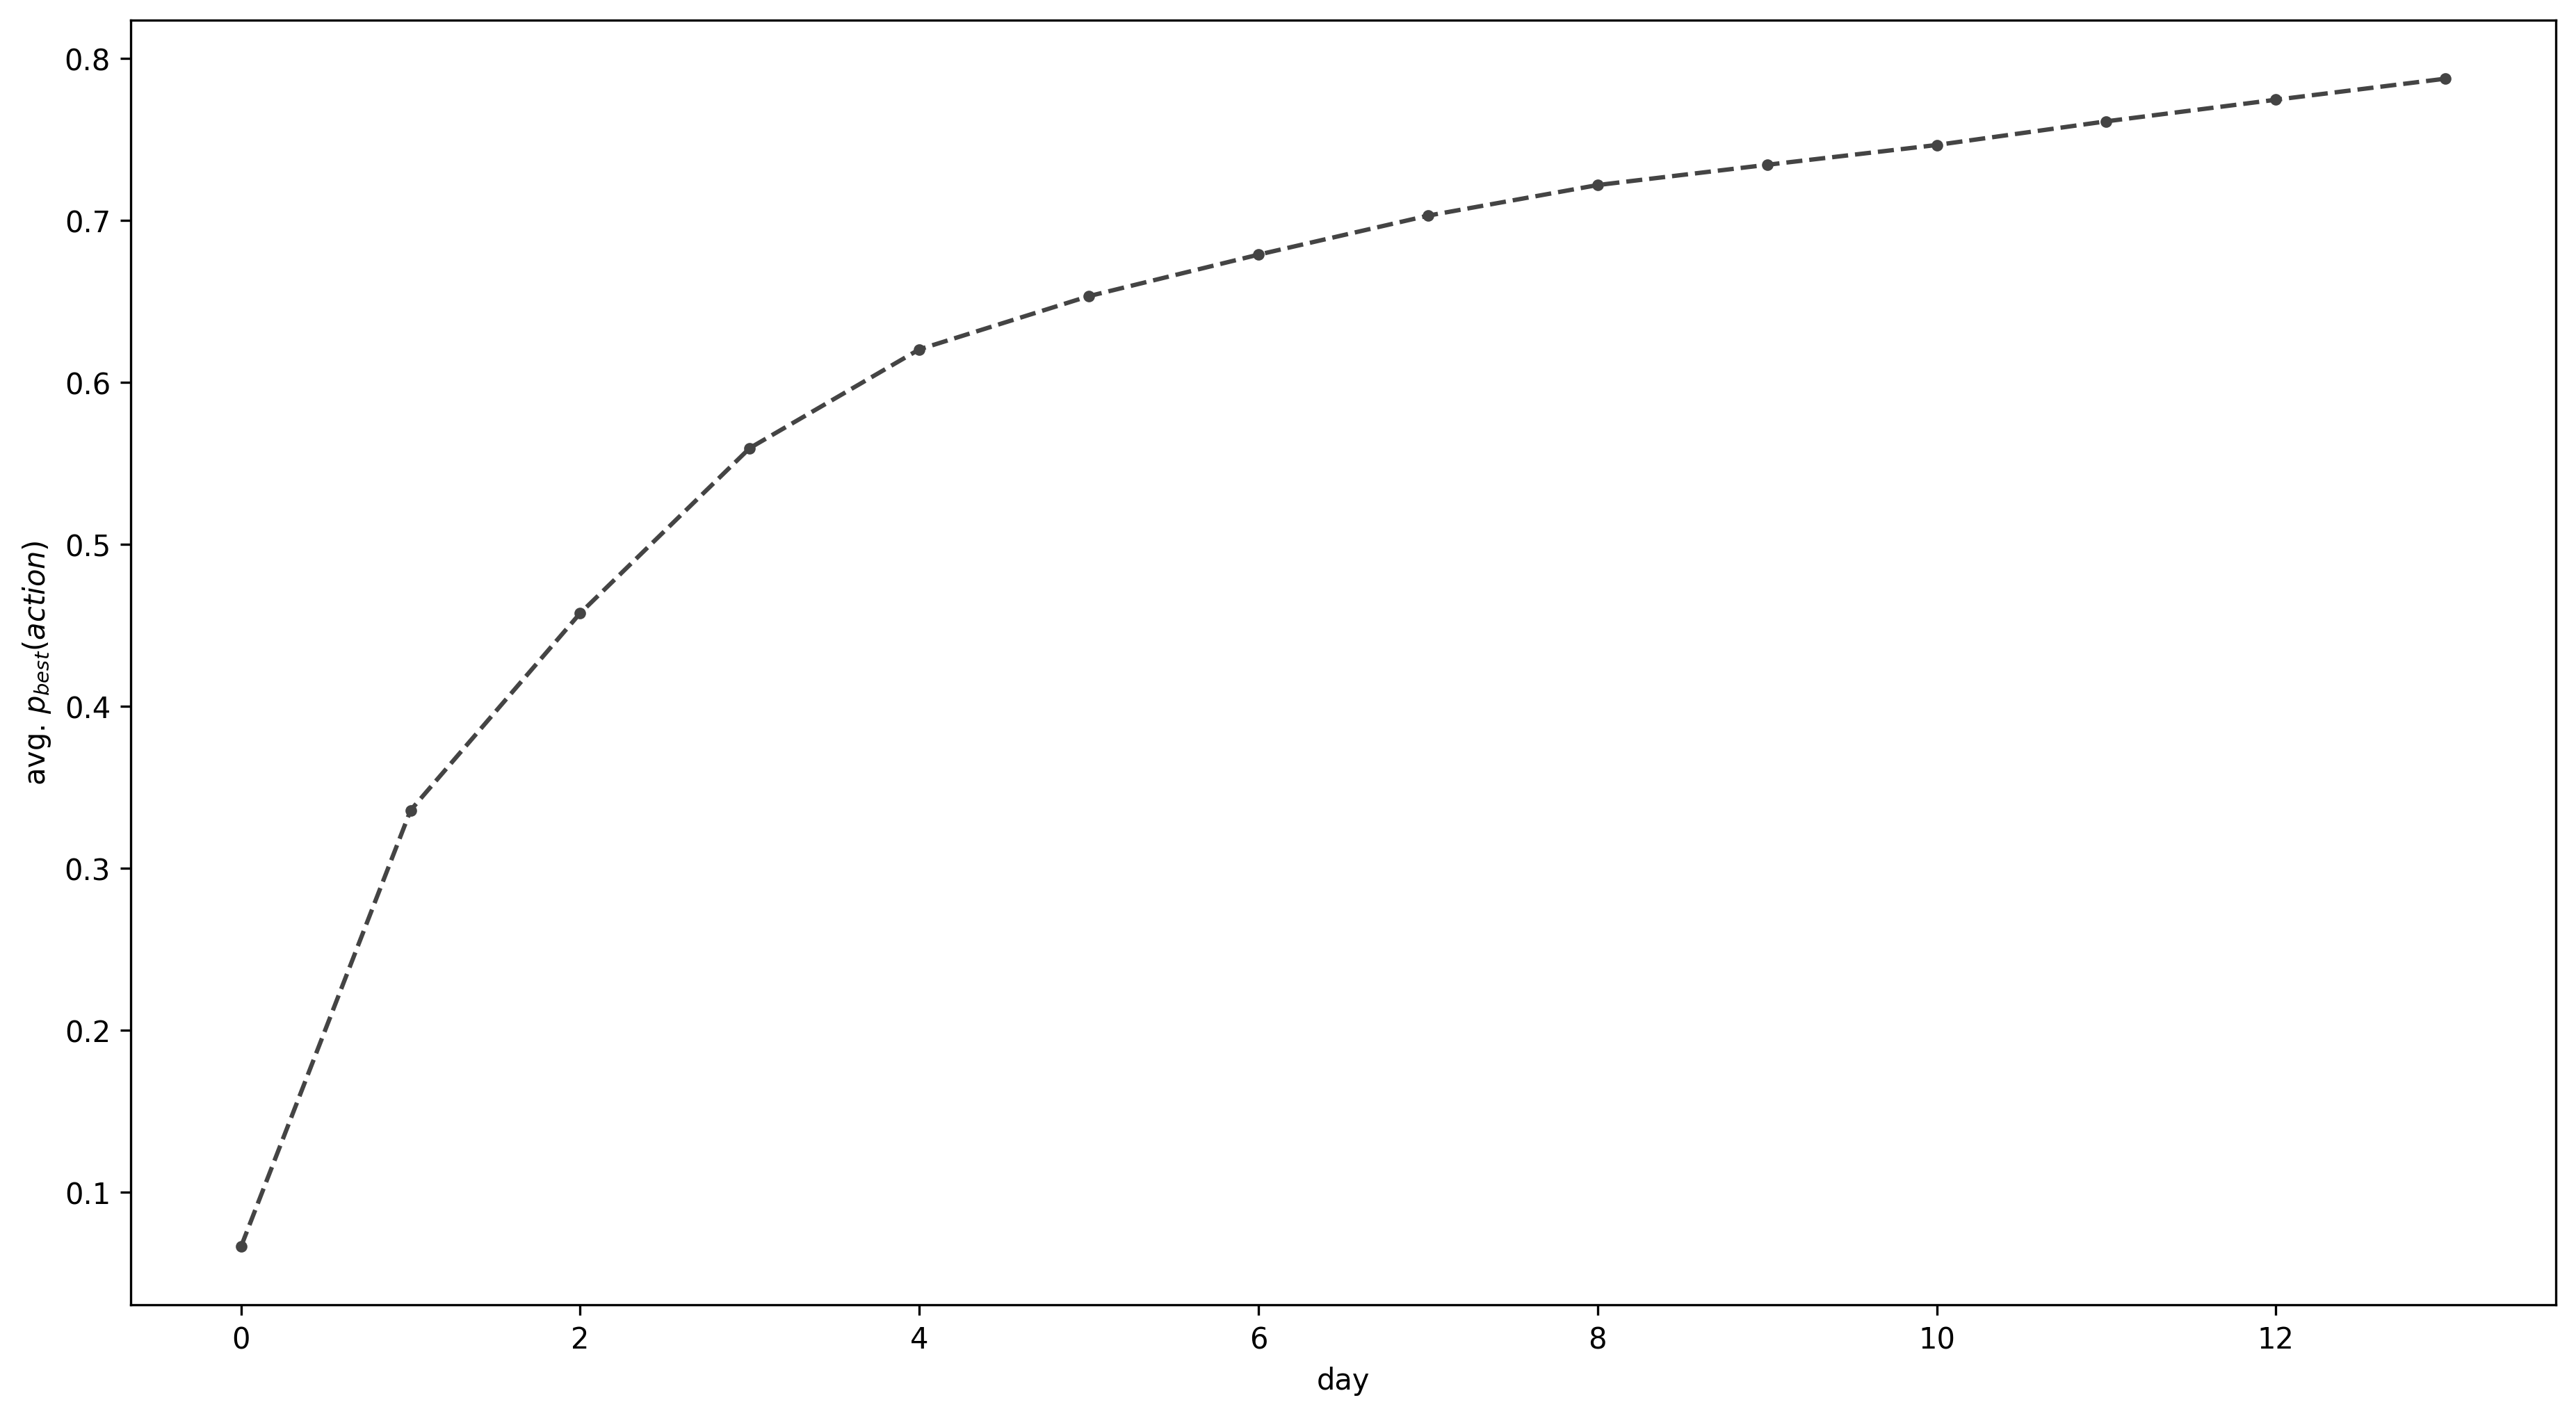

In [30]:
m = np.array(recommender.mean_vs_day)
plt.figure(figsize=(15,8))
plt.plot(m, '.--', color=e4e.color_1)
plt.xlabel('day')
plt.ylabel('avg. $p_{best}(action)$')
plt.show()